In [37]:
import csv
import glob
import re

In [38]:
from ete3 import Tree

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [40]:
tree = Tree("data/tree/time_tree.nw")
hsap = tree.get_leaves_by_name('homo_sapiens')

In [41]:
hsap_dist = dict()

In [42]:
for leaf in tree:
    name = leaf.name

    if name == "homo_sapiens":
        hsap_dist[name] = 0

    node = leaf.get_common_ancestor(hsap)
    _, age = node.get_farthest_leaf()

    hsap_dist[name] = age

In [43]:
EXON_TYPE_INDEX = {'FE': 0, 'IE': 1, 'LE': 2}

In [44]:
hsap_exon_data = dict()
hsap_gene_data = dict()

In [45]:
heatmap_data = {
    'pan_troglodytes': np.zeros((3, 3)),
    'panthera_pardus': np.zeros((3, 3))
}

In [46]:
with open("../data/ref/homo_sapiens/annot/out/meta_exon.csv", 'r') as f:
    reader = csv.reader(f)
    next(reader)

    for row in reader:
        gene, gene_func, chrom, beg, end, strand, exon_type, make_up = row

        strand = int(strand == "+")
        meta_exon = f"{chrom}:{beg}-{end}:{strand}"

        hsap_exon_data[meta_exon] = exon_type
        hsap_gene_data[meta_exon] = gene, gene_func

In [47]:
long_data = list()

In [48]:
for fp in glob.iglob("data/ref/*/annot/out/hsap_exon_homology.bed"):
    name = re.search("(?<=ref/)[^/]+", fp).group(0)
    dist = hsap_dist[name]

    if name == "homo_sapiens":
        continue

    count_data = {
        'supp_fig2a': {'N': 0, 't': 0},
        'supp_fig2b': {'N': 0, 't': 0}
    }

    with open(fp, 'r') as f:
        reader = csv.reader(f, delimiter="\t")

        for row in reader:
            overlap = int(row.pop(-1))

            if overlap:
                count_data['supp_fig2a']['N'] += 1
                count_data['supp_fig2a']['t'] += 1
            else:
                count_data['supp_fig2a']['t'] += 1
                continue

            h_chrom, *h_pos, h_exon, _, h_strand = row[:6]  # "h" prefix for H. sap.
            o_chrom, *o_pos, _, o_exon, o_strand = row[6:]  # "o" prefix for other species

            h_type = hsap_exon_data[h_exon]
            o_type, _ = o_exon.split("=")

            if h_type in EXON_TYPE_INDEX \
                    and o_type in EXON_TYPE_INDEX:
                count_data['supp_fig2b']['N'] += int(h_type == o_type)
                count_data['supp_fig2b']['t'] += 1

            if name in heatmap_data:
                if h_type not in EXON_TYPE_INDEX \
                        or o_type not in EXON_TYPE_INDEX:
                    continue

                m = EXON_TYPE_INDEX[h_type]
                j = EXON_TYPE_INDEX[o_type]

                heatmap_data[name][m, j] += 1

    long_data.append({
        'name': name,
        'dist': dist,
        '%_pos_on_exon': count_data['supp_fig2a']['N'] / count_data['supp_fig2a']['t'] * 100,
        '%_pos_on_type': count_data['supp_fig2b']['N'] / count_data['supp_fig2b']['t'] * 100,
    })

In [49]:
frame = pd.DataFrame(long_data)

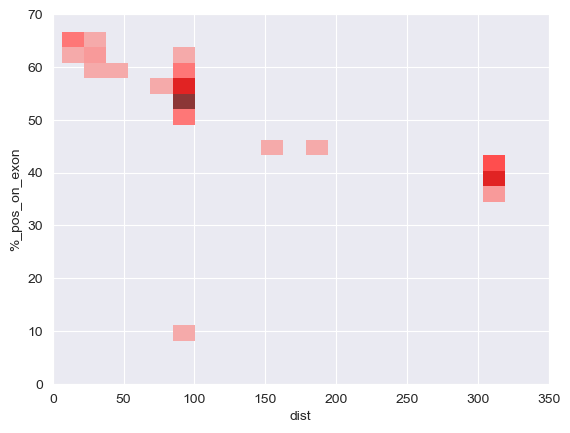

In [50]:
sns.histplot(frame, x='dist', y='%_pos_on_exon', bins=20, color='red')

_ = plt.ylim(0, 70)
_ = plt.xlim(0, 350)

plt.savefig("figs/supp2a.pdf")

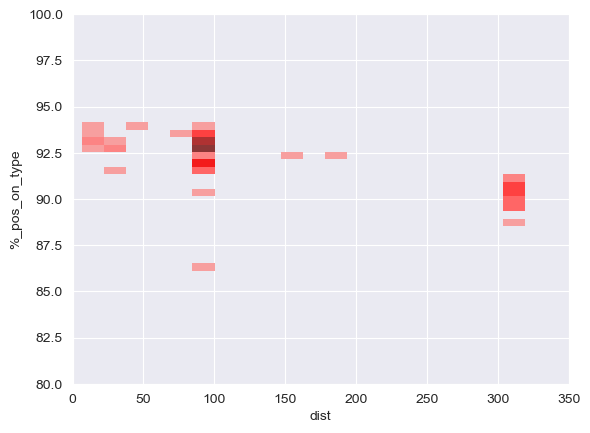

In [51]:
sns.histplot(frame, x='dist', y='%_pos_on_type', bins=20, color='red')

_ = plt.ylim(80, 100)
_ = plt.xlim(0, 350)

plt.savefig("figs/supp2b.pdf")

In [52]:
for name in heatmap_data:
    for i, row in enumerate(heatmap_data[name]):
        tot = sum(row)

        for j, count in enumerate(row):
            heatmap_data[name][i, j] = count / tot * 100


6.4


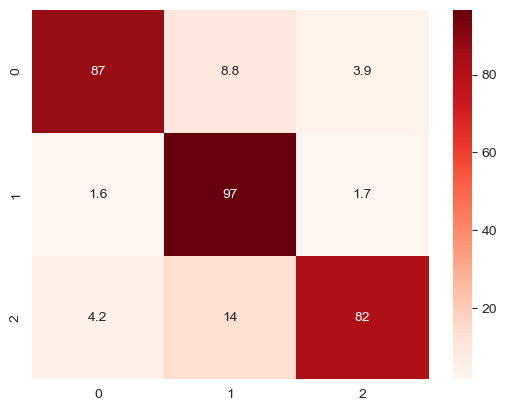

In [55]:
sns.heatmap(heatmap_data['pan_troglodytes'], annot=True, cmap='Reds')
print(hsap_dist['pan_troglodytes'])

plt.savefig("figs/supp2c_ptro.pdf")

94.09155


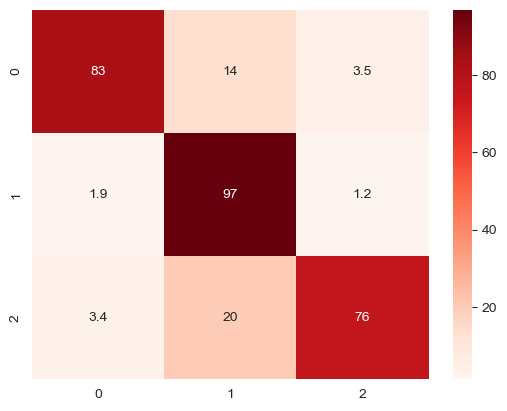

In [56]:
sns.heatmap(heatmap_data['panthera_pardus'], annot=True, cmap='Reds')
print(hsap_dist['panthera_pardus'])

plt.savefig("figs/supp2c_ppar.pdf")